In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
# sqlite 소스를 사용하기 위해 아래 jar 다운로드
# https://bitbucket.org/xerial/sqlite-jdbc/downloads/sqlite-jdbc-3.23.1.jar
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Example") \
    .config("spark.jars","miniproject2/lib/sqlite-jdbc-3.23.1.jar") \
    .getOrCreate()
spark

# 1. DataFrame
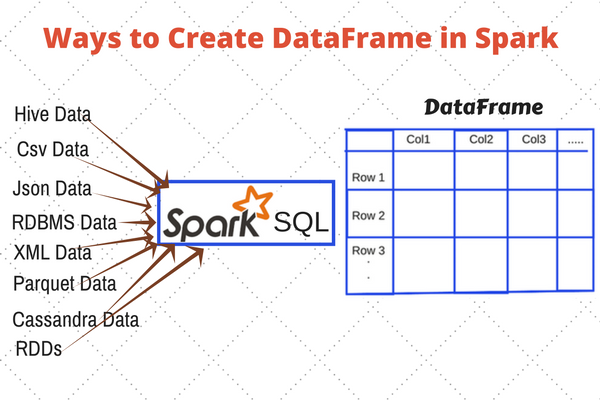
- 잘 정의된 로우와 컬럼을 가지는 분산 테이블 형태의 컬렉션
- 여러 언어 API와 직접 매핑되며, 각 언어에 대한 매핑 테이블을 가지고 있음
    - 매핑 테이블 참조 : https://www.oreilly.com/library/view/spark-the-definitive/9781491912201/ch04.html


In [2]:
spark.range(500).take(2)

[Row(id=0), Row(id=1)]

In [3]:
spark.range(500).show(2)

+---+
| id|
+---+
|  0|
|  1|
+---+
only showing top 2 rows



## 1.1 카탈리스트
- 실행 최적화 기능 제공
- 성능
    - https://www.google.com/search?q=spark+python+dataframe+performance&newwindow=1&source=lnms&tbm=isch&sa=X&ved=0ahUKEwijnb-ip5XkAhWLw4sBHRYuCtEQ_AUIEigC&biw=1900&bih=1287#imgrc=uV_tb0-6LII2CM:
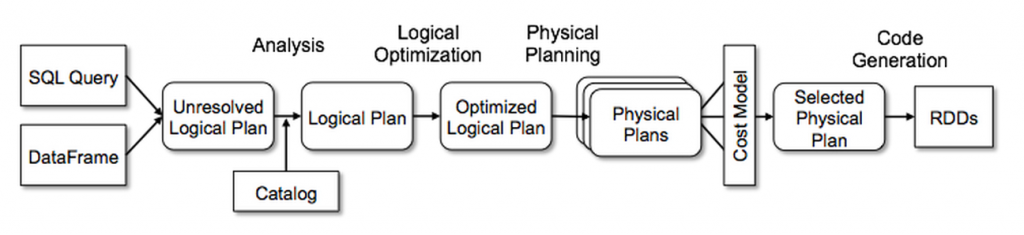

In [4]:
df = spark.range(500)
df.columns

['id']

In [6]:
%%timeit
# 파티션 4
spark.conf.set("spark.sql.shuffle.partitions", "4")
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)
step1 = df1.repartition(5)
step12 = df2.repartition(6)
step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])  
step4 = step3.selectExpr("sum(id)")
ret = step4.collect()

1 loop, best of 3: 5.24 s per loop


In [7]:
%%timeit
# 파티션 2
spark.conf.set("spark.sql.shuffle.partitions", "2")
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)
step1 = df1.repartition(5)
step12 = df2.repartition(6)
step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])  
step4 = step3.selectExpr("sum(id)")
ret = step4.collect()

1 loop, best of 3: 5.71 s per loop


In [8]:
%%timeit
# 파티션 1
spark.conf.set("spark.sql.shuffle.partitions", "1")
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)
step1 = df1.repartition(5)
step12 = df2.repartition(6)
step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])  
step4 = step3.selectExpr("sum(id)")
ret = step4.collect()

1 loop, best of 3: 7.92 s per loop


In [9]:
%%timeit
# 캐싱, 파티션 4
spark.conf.set("spark.sql.shuffle.partitions", "4")
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)
step1 = df1.repartition(5)
step12 = df2.repartition(6)
step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])  
step3.cache()
step4 = step3.selectExpr("sum(id)")
ret = step4.collect()

The slowest run took 50.90 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 115 ms per loop


## 1.2 생성 방법

### 1.2.1 데이터소스 생성, 임시뷰 생성

In [6]:
df = spark.read.format("json").load("miniproject2/data/read.json")
df.createOrReplaceTempView("dfTable")
spark.sql("SELECT * FROM dfTable LIMIT 2").collect()
df.show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|            Ireland|  252|
|            Egypt|      United States|   13|
|    United States|              India|   62|
|    United States|          Singapore|   25|
+-----------------+-------------------+-----+
only showing top 5 rows



### 1.2.2스키마, ROW 생성

In [7]:
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType
myManualSchema = StructType([
  StructField("some", StringType(), True),
  StructField("col", StringType(), True),
  StructField("names", LongType(), False)
])
myRow = Row("Hello", None, 1)
myDf = spark.createDataFrame([myRow], myManualSchema)
myDf.show()

+-----+----+-----+
| some| col|names|
+-----+----+-----+
|Hello|null|    1|
+-----+----+-----+



## 1.3 select와 selectExpr

In [8]:
df.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME").show(2)

+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
|    United States|            Croatia|
|    United States|            Ireland|
+-----------------+-------------------+
only showing top 2 rows



In [9]:
from pyspark.sql.functions import expr, col, column
df.select(
    expr("DEST_COUNTRY_NAME"),
    col("DEST_COUNTRY_NAME"),
    column("DEST_COUNTRY_NAME"))\
  .show(2)

+-----------------+-----------------+-----------------+
|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|
+-----------------+-----------------+-----------------+
|    United States|    United States|    United States|
|    United States|    United States|    United States|
+-----------------+-----------------+-----------------+
only showing top 2 rows



In [10]:
df.select(expr("DEST_COUNTRY_NAME AS destination")).show(2)

+-------------+
|  destination|
+-------------+
|United States|
|United States|
+-------------+
only showing top 2 rows



In [11]:
df.select(expr("DEST_COUNTRY_NAME as destination").alias("DEST_COUNTRY_NAME")).take(2)

[Row(DEST_COUNTRY_NAME=u'United States'),
 Row(DEST_COUNTRY_NAME=u'United States')]

In [12]:
df.selectExpr("DEST_COUNTRY_NAME as newColumnName", "DEST_COUNTRY_NAME").show(2)

+-------------+-----------------+
|newColumnName|DEST_COUNTRY_NAME|
+-------------+-----------------+
|United States|    United States|
|United States|    United States|
+-------------+-----------------+
only showing top 2 rows



In [13]:
df.selectExpr(
  "*", # all original columns
  "(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry")\
  .show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Croatia|    1|        false|
|    United States|            Ireland|  252|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



In [14]:
df.selectExpr("avg(count)", "count(distinct(DEST_COUNTRY_NAME))").show(2)

+------------------+---------------------------------+
|        avg(count)|count(DISTINCT DEST_COUNTRY_NAME)|
+------------------+---------------------------------+
|1723.1836734693877|                              127|
+------------------+---------------------------------+



In [21]:
from pyspark.sql.functions import lit
from pyspark.sql.functions import date_add, date_sub, col
df2 = df.select(expr("*"), lit(100).alias("OneHundred")) # , expr("(count < OneHundred) as isBig")
df2.show(5)
df3 = df2.selectExpr("*", "(count > OneHundred) as isBig")
df3.show(5)
df3.filter(df3.isBig).show(5)
df3.filter(col('count') <200).show(5)
df3.filter('count < 200 or ORIGIN_COUNTRY_NAME=="United States" and DEST_COUNTRY_NAME=="Egypt"').show(100)
df3.filter('ORIGIN_COUNTRY_NAME=="United States" and DEST_COUNTRY_NAME=="Egypt" or count < 200').show(100)
df3.filter('ORIGIN_COUNTRY_NAME=="United States" and DEST_COUNTRY_NAME=="Egypt"').show(100)

+-----------------+-------------------+-----+----------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|OneHundred|
+-----------------+-------------------+-----+----------+
|    United States|            Croatia|    1|       100|
|    United States|            Ireland|  252|       100|
|            Egypt|      United States|   13|       100|
|    United States|              India|   62|       100|
|    United States|          Singapore|   25|       100|
+-----------------+-------------------+-----+----------+
only showing top 5 rows

+-----------------+-------------------+-----+----------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|OneHundred|isBig|
+-----------------+-------------------+-----+----------+-----+
|    United States|            Croatia|    1|       100|false|
|    United States|            Ireland|  252|       100| true|
|            Egypt|      United States|   13|       100|false|
|    United States|              India|   62|       100|false|
|    United States|  

+--------------------+--------------------+-----+----------+-----+
|   DEST_COUNTRY_NAME| ORIGIN_COUNTRY_NAME|count|OneHundred|isBig|
+--------------------+--------------------+-----+----------+-----+
|       United States|             Croatia|    1|       100|false|
|               Egypt|       United States|   13|       100|false|
|       United States|               India|   62|       100|false|
|       United States|           Singapore|   25|       100|false|
|       United States|             Grenada|   46|       100|false|
|             Senegal|       United States|   31|       100|false|
|              Guyana|       United States|   65|       100|false|
|       United States|    Marshall Islands|   30|       100|false|
|             Bolivia|       United States|   35|       100|false|
|            Anguilla|       United States|   19|       100|false|
|       United States|            Paraguay|    5|       100|false|
|       United States|         Afghanistan|    5|       100|fa

In [28]:
print df3.filter('ORIGIN_COUNTRY_NAME=="United States" and (DEST_COUNTRY_NAME=="Egypt" or count < 200)').count()
print df3.filter('ORIGIN_COUNTRY_NAME=="United States" and DEST_COUNTRY_NAME=="Egypt" or count < 200').count()
print df3.filter('(ORIGIN_COUNTRY_NAME=="United States" and DEST_COUNTRY_NAME=="Egypt") or count < 200').count()

print df3.filter('ORIGIN_COUNTRY_NAME=="United States" and (DEST_COUNTRY_NAME=="Egypt" or count < 200)').show()
print df3.filter('ORIGIN_COUNTRY_NAME=="United States" and DEST_COUNTRY_NAME=="Egypt" or count < 200').show()

89
170
170
+--------------------+-------------------+-----+----------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|OneHundred|isBig|
+--------------------+-------------------+-----+----------+-----+
|               Egypt|      United States|   13|       100|false|
|             Senegal|      United States|   31|       100|false|
|              Guyana|      United States|   65|       100|false|
|             Bolivia|      United States|   35|       100|false|
|            Anguilla|      United States|   19|       100|false|
|Turks and Caicos ...|      United States|  183|       100| true|
|Saint Vincent and...|      United States|    6|       100|false|
|            Pakistan|      United States|   12|       100|false|
|             Iceland|      United States|  137|       100| true|
|    Marshall Islands|      United States|   60|       100|false|
|          Luxembourg|      United States|  111|       100| true|
|               Samoa|      United States|   25|       100|false|

## 1.4 컬럼 추가하기

In [38]:
df.withColumn("numberOne", lit(1)).show(2)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|numberOne|
+-----------------+-------------------+-----+---------+
|    United States|            Croatia|    1|        1|
|    United States|            Ireland|  252|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



In [39]:
df.withColumn("withinCountry", expr("ORIGIN_COUNTRY_NAME == DEST_COUNTRY_NAME"))\
  .show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Croatia|    1|        false|
|    United States|            Ireland|  252|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



## 1.5 컬럼명 변경하기

In [40]:
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns

['dest', 'ORIGIN_COUNTRY_NAME', 'count']

## 1.6 컬럼 데이터 타입 변경하기

In [41]:
from pyspark.sql.functions import col
print df.withColumn("count2", col("count").cast("string")).schema
print df.withColumn("count", col("count").cast("string")).schema

StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,LongType,true),StructField(count2,StringType,true)))
StructType(List(StructField(DEST_COUNTRY_NAME,StringType,true),StructField(ORIGIN_COUNTRY_NAME,StringType,true),StructField(count,StringType,true)))


## 1.7 컬럼 제거하기

In [42]:
df.drop("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").columns

['count']

## 1.8 예약 문자와 키워드
- 예약 문자 : 공백이나 하이픈
- 키워드 : 백틱 (\`\`)

In [20]:
from pyspark.sql.functions import expr
dfWithLongColName = df.withColumn(
    "This Long Column-Name 한글",
    expr("ORIGIN_COUNTRY_NAME"))

In [23]:
dfWithLongColName.selectExpr(
    "`This Long Column-Name 한글`",
    "`This Long Column-Name 한글` as `new col`")\
  .show(2)

+------------------------+-------+
|This Long Column-Name 한글|new col|
+------------------------+-------+
|                 Croatia|Croatia|
|                 Ireland|Ireland|
+------------------------+-------+
only showing top 2 rows



In [26]:
dfWithLongColName.select(
    "This Long Column-Name 한글")\
  .show(2)

+------------------------+
|This Long Column-Name 한글|
+------------------------+
|                 Croatia|
|                 Ireland|
+------------------------+
only showing top 2 rows



## 1.9 대소문자 구분

In [27]:
spark.conf.set("spark.sql.caseSensitive", "false")
df.select("DEST_COUNTRY_NAME").show(2)
df.select("dest_country_name").show(2)
spark.conf.set("spark.sql.caseSensitive", "true")
df.select("DEST_COUNTRY_NAME").show(2)
df.select("dest_country_name").show(2)
spark.conf.set("spark.sql.caseSensitive", "false")

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows

+-----------------+
|dest_country_name|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
+-----------------+
only showing top 2 rows



AnalysisException: u"cannot resolve '`dest_country_name`' given input columns: [DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME, count];;\n'Project ['dest_country_name]\n+- AnalysisBarrier\n      +- Relation[DEST_COUNTRY_NAME#329,ORIGIN_COUNTRY_NAME#330,count#331L] json\n"

## 1.10 필터링
- where나 filter를 사용할 수 있으며, 같은 연산을 수행한다.

In [46]:
df.where(col("count") < 2)\
.where(col("ORIGIN_COUNTRY_NAME") != "Croatia")\
.show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|               Togo|    1|
|    United States|    Solomon Islands|    1|
+-----------------+-------------------+-----+
only showing top 2 rows



## 1.11 사용자 정의 함수 (UDF)

In [47]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col

def power3(double_value):
    return double_value ** 3
power3udf = udf(power3)

udfExampleDF = spark.range(5).toDF("num")
udfExampleDF.select(col("num"), power3udf(col("num"))).show(5)

+---+-----------+
|num|power3(num)|
+---+-----------+
|  0|          0|
|  1|          1|
|  2|          8|
|  3|         27|
|  4|         64|
+---+-----------+



## 1.12 repartition과 coalesce
- repartition은 무조건 데이터 셔플, 향후 사용할 파티션 수가 현재 보다 많거나, 컬럼을 기준으로 파티션을 만드는 경우에 사용
- 특정 컬럼을 기준으로 자주 필터링 한다면, 자주 필터링 되는 컬럼을 기준으로 파티션을 재분배하는 것이 좋음
- coalesce은 셔플하지 않고 파티션을 병합하는 경우 사용

In [30]:
from pyspark.sql.functions import col
df.repartition(5).show(1)
df.repartition(col("DEST_COUNTRY_NAME")).show(1)
df.repartition(5, col("DEST_COUNTRY_NAME")).show(1)
df.repartition(5, col("DEST_COUNTRY_NAME")).coalesce(2).show(1)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|         Colombia|      United States|  759|
+-----------------+-------------------+-----+
only showing top 1 row

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Senegal|      United States|   31|
+-----------------+-------------------+-----+
only showing top 1 row

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Bolivia|      United States|   35|
+-----------------+-------------------+-----+
only showing top 1 row

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Bolivia|      United States|   35|
+-----------------+-------------------+-----+
only sho

## 1.13 집계 함수

In [51]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("miniproject2/data/online-retail-dataset.csv")
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [29]:
from pyspark.sql.functions import count
df.select(count("StockCode")).show()

+----------------+
|count(StockCode)|
+----------------+
|          541909|
+----------------+



In [30]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("StockCode")).show() # 4070

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                     4070|
+-------------------------+



In [31]:
# 최대 추정 오류율 파라미터 사용, countDistinct보다 빠른 결과 반환, 대규모 데이터 셋을 사용할 때 좋음
from pyspark.sql.functions import approx_count_distinct
df.select(approx_count_distinct("StockCode", 0.1)).show() # 3364

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                            3364|
+--------------------------------+



In [33]:
from pyspark.sql.functions import first, last
from pyspark.sql.functions import min, max
df.select(first("StockCode"), last("StockCode"), min("Quantity"), max("Quantity")).show()

+-----------------------+----------------------+-------------+-------------+
|first(StockCode, false)|last(StockCode, false)|min(Quantity)|max(Quantity)|
+-----------------------+----------------------+-------------+-------------+
|                 85123A|                 22138|       -80995|        80995|
+-----------------------+----------------------+-------------+-------------+



In [34]:
from pyspark.sql.functions import sum
df.select(sum("Quantity")).show() # 5176450

+-------------+
|sum(Quantity)|
+-------------+
|      5176450|
+-------------+



In [40]:
# 평균 거래 횟수 구하는 3가지 방법
from pyspark.sql.functions import sum, count, avg, expr

df.select(
    count("Quantity").alias("total_transactions"),
    sum("Quantity").alias("total_purchases"),
    avg("Quantity").alias("avg_purchases"),
    expr("mean(Quantity)").alias("mean_purchases"))\
  .selectExpr(
    "total_purchases/total_transactions",
    "avg_purchases",
    "mean_purchases").show()

+--------------------------------------+----------------+----------------+
|(total_purchases / total_transactions)|   avg_purchases|  mean_purchases|
+--------------------------------------+----------------+----------------+
|                      9.55224954743324|9.55224954743324|9.55224954743324|
+--------------------------------------+----------------+----------------+



## 1.13 그룹

In [38]:
from pyspark.sql.functions import count
# agg 여러 집계를 한번에 지정할 수 있고 표현식도 사용 가능
df.groupBy("InvoiceNo").agg(
    count("Quantity").alias("quan"),
    expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536365|   7|              7|
|   536366|   2|              2|
|   536367|  12|             12|
|   536368|   4|              4|
|   536369|   1|              1|
|   536370|  20|             20|
|   536371|   1|              1|
|   536372|   2|              2|
|   536373|  16|             16|
|   536374|   1|              1|
|   536375|  16|             16|
|   536376|   2|              2|
|   536377|   2|              2|
|   536378|  19|             19|
|   536380|   1|              1|
|   536381|  35|             35|
|  C536379|   1|              1|
|   536382|  12|             12|
|  C536383|   1|              1|
|   536384|  13|             13|
+---------+----+---------------+
only showing top 20 rows



## 1.14 날짜와 타임스탬프 다루기

In [31]:
from pyspark.sql.functions import current_date, current_timestamp
dateDF = spark.range(10)\
  .withColumn("today", current_date())\
  .withColumn("now", current_timestamp())
dateDF.show()

+---+----------+--------------------+
| id|     today|                 now|
+---+----------+--------------------+
|  0|2019-08-22|2019-08-22 08:37:...|
|  1|2019-08-22|2019-08-22 08:37:...|
|  2|2019-08-22|2019-08-22 08:37:...|
|  3|2019-08-22|2019-08-22 08:37:...|
|  4|2019-08-22|2019-08-22 08:37:...|
|  5|2019-08-22|2019-08-22 08:37:...|
|  6|2019-08-22|2019-08-22 08:37:...|
|  7|2019-08-22|2019-08-22 08:37:...|
|  8|2019-08-22|2019-08-22 08:37:...|
|  9|2019-08-22|2019-08-22 08:37:...|
+---+----------+--------------------+



In [32]:
# today에 5일을 빼고 더함
from pyspark.sql.functions import date_add, date_sub, col
dateDF.select(date_sub(col("today"), 5), date_add(col("today"), 5)).show(1)

+------------------+------------------+
|date_sub(today, 5)|date_add(today, 5)|
+------------------+------------------+
|        2019-08-17|        2019-08-27|
+------------------+------------------+
only showing top 1 row



In [43]:
from pyspark.sql.functions import to_date, lit
dateFormat = "yyyy-dd-MM"
cleanDateDF = spark.range(1).select(
    to_date(lit("2017-12-11 23:00"), dateFormat).alias("date"),
    to_date(lit("2017-20-12"), dateFormat).alias("date2"))
cleanDateDF.show()

+----------+----------+
|      date|     date2|
+----------+----------+
|2017-11-12|2017-12-20|
+----------+----------+



In [19]:
from pyspark.sql.functions import to_timestamp
dateFormat = "yyyy-dd-MM"
cleanDateDF.select(to_timestamp(col("date"), dateFormat)).show()

+----------------------------------+
|to_timestamp(`date`, 'yyyy-dd-MM')|
+----------------------------------+
|               2017-11-12 00:00:00|
+----------------------------------+



In [48]:
cleanDateDF.filter(col("date2") > "2017-12-19 01:00:00").show()
cleanDateDF.filter(col("date2") < "2017-12-12").show()

+----------+----------+
|      date|     date2|
+----------+----------+
|2017-11-12|2017-12-20|
+----------+----------+

+----+-----+
|date|date2|
+----+-----+
+----+-----+



# 2. DataSource

- CSV, JSON, 파케이, ORC, JDBC/ODBC 연결, 일반 텍스트 파일
- 카산드라, HBase, 몽고디비, AWS Redshift, XML, 기타 수 많은 데이터소스

## parquet

- 스키마가 파일 자체에 내장
- 높은 압축률

In [49]:
df = spark.read.format("parquet") \
.load("miniproject2/data/2010-summary.parquet")
print df.take(5)

[Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Romania', count=1), Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Ireland', count=264), Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'India', count=69), Row(DEST_COUNTRY_NAME=u'Egypt', ORIGIN_COUNTRY_NAME=u'United States', count=24), Row(DEST_COUNTRY_NAME=u'Equatorial Guinea', ORIGIN_COUNTRY_NAME=u'United States', count=1)]


In [50]:
df.write.format("parquet").mode("overwrite").save("miniproject2/data/write.parquet")

## Sqlite

In [51]:
url = 'jdbc:sqlite:miniproject2/data/my-sqlite.db'
tablename = 'flight_info'

In [52]:
src_df = spark.read.format("jdbc") \
.option("url", url) \
.option("dbtable", tablename) \
.option("driver", "org.sqlite.JDBC") \
.load()
print src_df.count()

255


In [53]:
src_df.write.format("jdbc")\
    .option("url", "jdbc:sqlite:miniproject2/data/write.db")\
    .option("dbtable", 'flight_info')\
    .option("driver", "org.sqlite.JDBC")\
    .mode("overwrite")\
    .save()

# 미니프로젝트 2

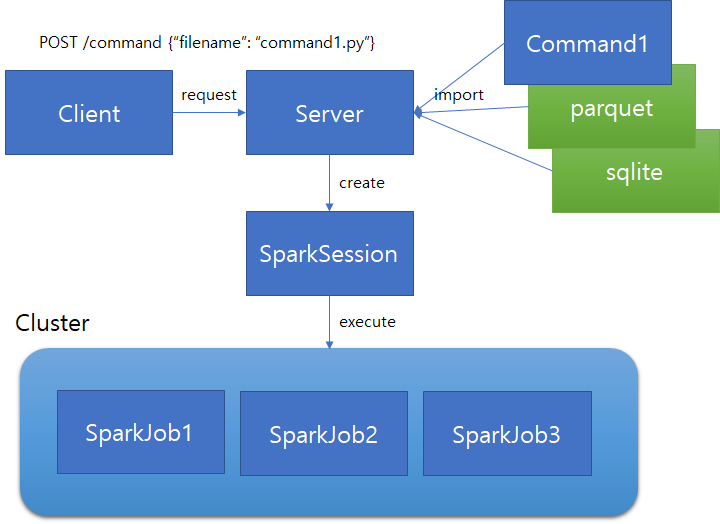

## 데이터베이스 병렬로 읽기

In [54]:
url = 'jdbc:sqlite:miniproject2/data/dump.db'
tablename = 'flight_info'
colName = "count"
props = {"driver":"org.sqlite.JDBC"}
lowerBound = 0L
upperBound = 348113L

In [16]:
# 데이터가 적을때는 파티션단위로 끊지 않음
spark.read.format("jdbc")\
.option("url", url).option("dbtable", tablename).option("driver",  "org.sqlite.JDBC")\
.option("numPartitions", 10).load().count()

166912

In [55]:
spark.read.jdbc(url, tablename, column=colName, properties=props,lowerBound=lowerBound, upperBound=upperBound, numPartitions=1).count()

166912

In [56]:
spark.read.jdbc(url, tablename, column=colName, properties=props,lowerBound=lowerBound, upperBound=upperBound, numPartitions=10).count()

166912

## 파티셔닝

- 모든 파일 기반의 데이터 소스에서 지원
- 어떤 데이터를 어디에 저장할 것인지 제어할 수 있는 기능


In [57]:
csvFile = spark.read.format("csv") \
.option("header", "true") \
.option("inferSchema", "true") \
.load("miniproject2/data/read.csv")

### count 컬럼 기준으로 csv파일로 파티셔닝

In [58]:
csvFile.select("DEST_COUNTRY_NAME", "count")\
.write.partitionBy("count")\
.mode("overwrite")\
.text("miniproject2/data/write.csv.partition")

In [59]:
spark.read.format("csv") \
.option("header", "true") \
.option("inferSchema", "true") \
.load("miniproject2/data/write.csv.partition/count=1").take(5)

[Row(United States=u'United States'),
 Row(United States=u'Moldova'),
 Row(United States=u'Malta'),
 Row(United States=u'United States'),
 Row(United States=u'Saint Vincent and the Grenadines')]

In [60]:
spark.read.format("csv") \
.option("header", "true") \
.option("inferSchema", "true") \
.load(["miniproject2/data/write.csv.partition/count=2", "miniproject2/data/write.csv.partition/count=3"]).collect()

[Row(Liberia=u'Hungary'),
 Row(Liberia=u'United States'),
 Row(Liberia=u'Malaysia'),
 Row(Liberia=u'Croatia'),
 Row(Liberia=u'United States'),
 Row(Liberia=u'United States'),
 Row(Liberia=u'Georgia'),
 Row(Liberia=u'Niger'),
 Row(Liberia=u'United States'),
 Row(Liberia=u'Greenland'),
 Row(Liberia=u'Thailand'),
 Row(Liberia=u'United States'),
 Row(Liberia=u'Singapore'),
 Row(Liberia=u'Tunisia'),
 Row(Liberia=u'Papua New Guinea'),
 Row(Liberia=u'Bulgaria')]

### DEST_COUNTRY_NAME 컬럼 기준으로 parquet파일로 파티셔닝

In [61]:
csvFile.write.mode("overwrite").format("parquet").partitionBy("DEST_COUNTRY_NAME")\
  .save("miniproject2/data/write.parquet.partition")

In [62]:
spark.read.format("parquet") \
.load(["miniproject2/data/write.parquet.partition/DEST_COUNTRY_NAME=United States"]).take(5)

[Row(ORIGIN_COUNTRY_NAME=u'Romania', count=15),
 Row(ORIGIN_COUNTRY_NAME=u'Croatia', count=1),
 Row(ORIGIN_COUNTRY_NAME=u'Ireland', count=344),
 Row(ORIGIN_COUNTRY_NAME=u'India', count=62),
 Row(ORIGIN_COUNTRY_NAME=u'Singapore', count=1)]

In [63]:
spark.read.format("parquet") \
.load(["miniproject2/data/write.parquet.partition"]).count()

256

In [62]:
csvFile.write.format("jdbc")\
    .option("url", "jdbc:sqlite:miniproject2/data/write.db.partition")\
    .option("dbtable", 'flight_info')\
    .option("driver", "org.sqlite.JDBC")\
    .mode("overwrite")\
    .partitionBy("DEST_COUNTRY_NAME")\
    .save()

In [ ]:
csvFile.write.mode("overwrite").partitionBy("DEST_COUNTRY_NAME")\
  .save("miniproject2/data/write.parquet.partition")

# 데이터베이스 병렬로 읽기

In [13]:
spark.read.format("jdbc") \
.option("url", 'jdbc:sqlite:miniproject2/data/dump.db') \
.option("dbtable", 'flight_info') \
.option("driver", "org.sqlite.JDBC") \
.option("numPartitions", 400) \
.load() \
.take(10)

[Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Romania', count=15),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Croatia', count=1),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Ireland', count=344),
 Row(DEST_COUNTRY_NAME=u'Egypt', ORIGIN_COUNTRY_NAME=u'United States', count=15),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'India', count=62),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Singapore', count=1),
 Row(DEST_COUNTRY_NAME=u'United States', ORIGIN_COUNTRY_NAME=u'Grenada', count=62),
 Row(DEST_COUNTRY_NAME=u'Costa Rica', ORIGIN_COUNTRY_NAME=u'United States', count=588),
 Row(DEST_COUNTRY_NAME=u'Senegal', ORIGIN_COUNTRY_NAME=u'United States', count=40),
 Row(DEST_COUNTRY_NAME=u'Moldova', ORIGIN_COUNTRY_NAME=u'United States', count=1)]

In [11]:
%timeit spark.read.format("jdbc") \
.option("url", 'jdbc:sqlite:miniproject2/data/dump.db') \
.option("dbtable", 'flight_info') \
.option("driver", "org.sqlite.JDBC") \
.load() \
.take(10)

1 loop, best of 3: 350 ms per loop


# 쿼리 푸시 다운

In [2]:
pushdownQuery = """
SELECT * 
FROM flight_info
WHERE DEST_COUNTRY_NAME="United States"
"""
df = spark.read.format("parquet").option("dbtable", pushdownQuery).load("miniproject2/data/write.parquet.partition/DEST_COUNTRY_NAME=United States")
df.collect()

[Row(ORIGIN_COUNTRY_NAME=u'Romania', count=15),
 Row(ORIGIN_COUNTRY_NAME=u'Croatia', count=1),
 Row(ORIGIN_COUNTRY_NAME=u'Ireland', count=344),
 Row(ORIGIN_COUNTRY_NAME=u'India', count=62),
 Row(ORIGIN_COUNTRY_NAME=u'Singapore', count=1),
 Row(ORIGIN_COUNTRY_NAME=u'Grenada', count=62),
 Row(ORIGIN_COUNTRY_NAME=u'Sint Maarten', count=325),
 Row(ORIGIN_COUNTRY_NAME=u'Marshall Islands', count=39),
 Row(ORIGIN_COUNTRY_NAME=u'Paraguay', count=6),
 Row(ORIGIN_COUNTRY_NAME=u'Gibraltar', count=1),
 Row(ORIGIN_COUNTRY_NAME=u'Federated States of Micronesia', count=69),
 Row(ORIGIN_COUNTRY_NAME=u'Russia', count=161),
 Row(ORIGIN_COUNTRY_NAME=u'Netherlands', count=660),
 Row(ORIGIN_COUNTRY_NAME=u'Senegal', count=42),
 Row(ORIGIN_COUNTRY_NAME=u'Angola', count=13),
 Row(ORIGIN_COUNTRY_NAME=u'Anguilla', count=38),
 Row(ORIGIN_COUNTRY_NAME=u'Ecuador', count=300),
 Row(ORIGIN_COUNTRY_NAME=u'Cyprus', count=1),
 Row(ORIGIN_COUNTRY_NAME=u'Portugal', count=134),
 Row(ORIGIN_COUNTRY_NAME=u'Costa Rica', coun

## filter

In [3]:
df = spark.read.format("parquet").load("miniproject2/data/write.parquet.partition")
df.filter(df.DEST_COUNTRY_NAME=="United States").collect()

[Row(ORIGIN_COUNTRY_NAME=u'Romania', count=15, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Croatia', count=1, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Ireland', count=344, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'India', count=62, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Singapore', count=1, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Grenada', count=62, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Sint Maarten', count=325, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Marshall Islands', count=39, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Paraguay', count=6, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Gibraltar', count=1, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Federated States of Micronesia', count=69, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Russia', co

## where

In [4]:
df = spark.read.format("parquet").load("miniproject2/data/write.parquet.partition")
# df.where(df.DEST_COUNTRY_NAME=="United States").collect()
df.where(df.DEST_COUNTRY_NAME=="United States").collect()

[Row(ORIGIN_COUNTRY_NAME=u'Romania', count=15, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Croatia', count=1, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Ireland', count=344, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'India', count=62, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Singapore', count=1, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Grenada', count=62, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Sint Maarten', count=325, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Marshall Islands', count=39, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Paraguay', count=6, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Gibraltar', count=1, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Federated States of Micronesia', count=69, DEST_COUNTRY_NAME=u'United States'),
 Row(ORIGIN_COUNTRY_NAME=u'Russia', co

In [2]:
spark.read.format("parquet").load("miniproject2/data/write.parquet.partition").count()

245

In [3]:
spark.read.format("parquet").load("miniproject2/data/write.parquet").count()

245

In [14]:
%timeit spark.read.format("parquet").load("miniproject2/data/write.parquet.partition/DEST_COUNTRY_NAME=United States").collect()

10 loops, best of 3: 80 ms per loop


In [15]:
%timeit spark.read.format("parquet").load("miniproject2/data/write.parquet").collect()

10 loops, best of 3: 84.6 ms per loop


## Partition

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("Example") \
    .config("spark.jars","miniproject2/lib/sqlite-jdbc-3.23.1.jar") \
    .getOrCreate()

In [11]:
from pyspark.sql import functions as F
url = 'jdbc:sqlite:miniproject2/data/dump.db'
tablename = 'flight_info'
colName = "count"
props = {"driver":"org.sqlite.JDBC"}
lowerBound = 0L
upperBound = 348113L
numPartitions = 4

In [12]:
%timeit spark.read.jdbc(url, tablename, properties=props)\
.select(F.sum("count")).collect()

The slowest run took 4.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 159 ms per loop


In [20]:
spark.read.jdbc(url, tablename, column=colName, properties=props,lowerBound=lowerBound, upperBound=upperBound, numPartitions=1)\
.select(F.sum("count")).explain()

== Physical Plan ==
*(2) HashAggregate(keys=[], functions=[sum(cast(count#849 as bigint))])
+- Exchange SinglePartition
   +- *(1) HashAggregate(keys=[], functions=[partial_sum(cast(count#849 as bigint))])
      +- *(1) Scan JDBCRelation(flight_info) [numPartitions=1] [count#849] PushedFilters: [], ReadSchema: struct<count:int>


In [21]:
spark.read.jdbc(url, tablename, column=colName, properties=props,lowerBound=lowerBound, upperBound=upperBound, numPartitions=4)\
.select(F.sum("count")).explain()

== Physical Plan ==
*(2) HashAggregate(keys=[], functions=[sum(cast(count#860 as bigint))])
+- Exchange SinglePartition
   +- *(1) HashAggregate(keys=[], functions=[partial_sum(cast(count#860 as bigint))])
      +- *(1) Scan JDBCRelation(flight_info) [numPartitions=4] [count#860] PushedFilters: [], ReadSchema: struct<count:int>
